In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple


class FactorModel(nn.Module):
    def __init__(self, N: int, K: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.K = K  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, K[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.randn(K[i] - 1)) for i in range(N)]
        )

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [
            torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1)
            for logit in logits
        ]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities


def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n])
    nll_loss = total_loss.clone()
    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss


def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:

    v = torch.randn(len(answers), model.d, requires_grad=True)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(list(model.parameters()) + [v], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        # if epoch % 100 == 0:
        # print(f"Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}")
    print(
        f"d: {model.d}, Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}"
    )
    return model, v

In [2]:
import json

with open("formated_output_questions_v2.json") as f:
    data = json.load(f)
Q = data.values()
K = []
for q in Q:
    choice = q["choices"].values()
    K.append(len(choice))

In [3]:
# get the file name that starts with "QnA"
import os
import re

file_list = os.listdir(".")
file_list.sort()
file_list = [f for f in file_list if re.match(r"^v2_auto", f)]
# save the file list to csv file:
import pandas as pd

df = pd.DataFrame(file_list, columns=["file_name"])
df.to_csv("auto_QnA_file_list.csv", index=False)
file_list

['v2_auto_QnA_summary_Russo_Ukrainian_War_eng.json',
 'v2_auto_QnA_summary_Russo_Ukrainian_War_zho.json']

In [4]:
import json
import numpy as np


def extract_answers(file):
    with open(file) as f:
        data = json.load(f)

    # Initialize a list to store the extracted values
    answers = []

    # Iterate through the JSON objects to extract `post_LLM_answer`
    for item in data:

        if "answers" in item:
            # get the value under the key `answers`
            answer = item["answers"]
            answers.append(list(answer.values()))
    for a in answers:
        print(a)
    # convert the list of extracted values to a numpy array
    answers = np.array(answers, dtype=object)
    answers = np.where(answers == "A", 0, answers)
    answers = np.where(answers == "B", 1, answers)
    answers = np.where(answers == "C", 2, answers)
    answers = np.where(answers == "D", 3, answers)
    answers = np.where(answers == "E", 4, answers)
    # answers = np.where(answers == ".", 0, answers)
    # find the answer that is "."
    # idx = np.where(answers == ".")
    # idx = list(zip(*idx))
    answers = answers.astype(int)
    return answers

In [6]:
answers = []
for file in file_list:
    answer = extract_answers(file)
    answers.append(answer)
answers = np.array(answers)

# reshape answers to 600,80
answers = answers.reshape(200, 8)
answers.max()

['E', 'B', 'E', 'A', 'B', 'B', 'B', 'B']
['E', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'B', 'E', 'B', 'B', 'B', 'B', 'B']
['B', 'B', 'B', 'B', 'B', 'E', 'B', 'B']
['B', 'B', 'B', 'D', 'B', 'E', 'B', 'B']
['D', 'D', 'D', 'E', 'D', 'D', 'D', 'D']
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'C', 'E', 'E', 'E', 'E']
['E', 'E', 'E', 'E', 'E', 'A', 'E', 'E']
['B', 'B', 'B', 

4

In [7]:
print(K)

[5, 5, 5, 5, 5, 5, 5, 5]


In [8]:
ans_max = list(answers.max(axis=0) + 1)
for i in range(len(ans_max)):
    if ans_max[i] > K[i]:
        print(i + 1, ans_max[i], K[i])

In [9]:
import torch

answers = torch.tensor(answers, dtype=torch.long)

In [10]:
N = len(K)  # Number of questions

M = answers.shape[0]  # Number of articles

In [11]:
N, M

(8, 200)

In [12]:
epo = 10000

# for d in [3] + list(range(5, 41, 5)):

for d in [4, 3]:
    model = FactorModel(N, K, d)
    trained_model, v = train_model(
        model, answers, epochs=epo, lr=0.01, lambda1=0.01, lambda2=0.01
    )
    # Extract the latent vectors v
    latent_vectors = v.detach().numpy()
    # save the latent vectors to csv file
    np.savetxt(
        f"v2_latent_vectors_{d}.csv",
        latent_vectors,
        delimiter=",",
    )

/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


d: 4, Epoch 9999, Loss: 25.417407989501953, nll_loss: 4.334518909454346
d: 3, Epoch 9999, Loss: 36.99887466430664, nll_loss: 8.374982833862305


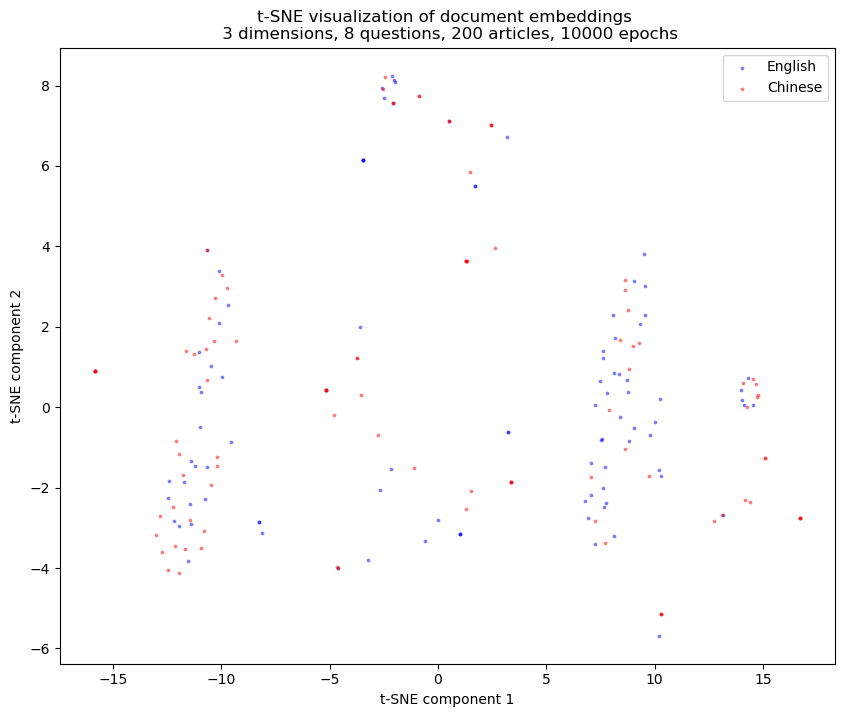

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Normalize the latent vectors
# scaler = StandardScaler()
# latent_vectors_normalized = scaler.fit_transform(latent_vectors)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)

v_2d = tsne.fit_transform(latent_vectors)

# Plot the 2D embeddings with the inedx of each point
plt.figure(figsize=(10, 8))

for index, (x, y) in enumerate(v_2d):
    if index >= 100:
        plt.scatter(
            x, y, alpha=0.4, color="red", s=3, label="Chinese" if index == 100 else ""
        )
    else:
        plt.scatter(
            x, y, alpha=0.4, color="blue", s=3, label="English" if index == 0 else ""
        )
    # plt.text(x, y, str(index), fontsize=9, color="blue")

plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)

plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend()
plt.show()

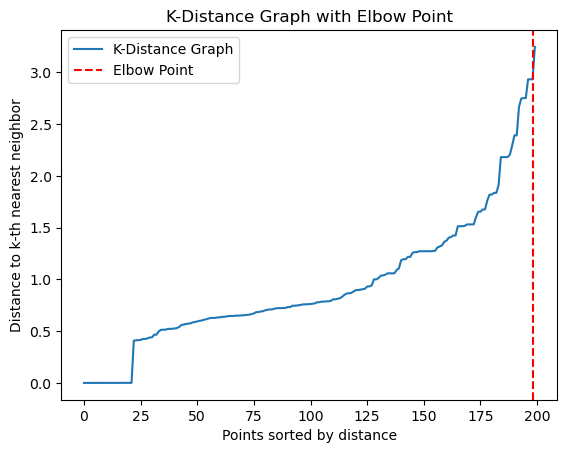

Elbow point (knee) is at index: 198, distance: 2.931902639146172


In [14]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Compute k-nearest neighbors (k is set to min_samples)
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(v_2d)
distances, indices = nbrs.kneighbors(v_2d)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, min_samples - 1])

x = np.arange(len(distances))
kneedle = KneeLocator(x, distances, curve="convex", direction="increasing")

# Plot the results
plt.plot(x, distances, label="K-Distance Graph")
plt.axvline(x=kneedle.knee, color="r", linestyle="--", label="Elbow Point")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to k-th nearest neighbor")
plt.title("K-Distance Graph with Elbow Point")
plt.legend()
plt.show()

# Print the knee point
print(
    f"Elbow point (knee) is at index: {kneedle.knee}, distance: {distances[kneedle.knee]}"
)

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=distances[kneedle.knee], min_samples=min_samples)
labels = dbscan.fit_predict(v_2d)

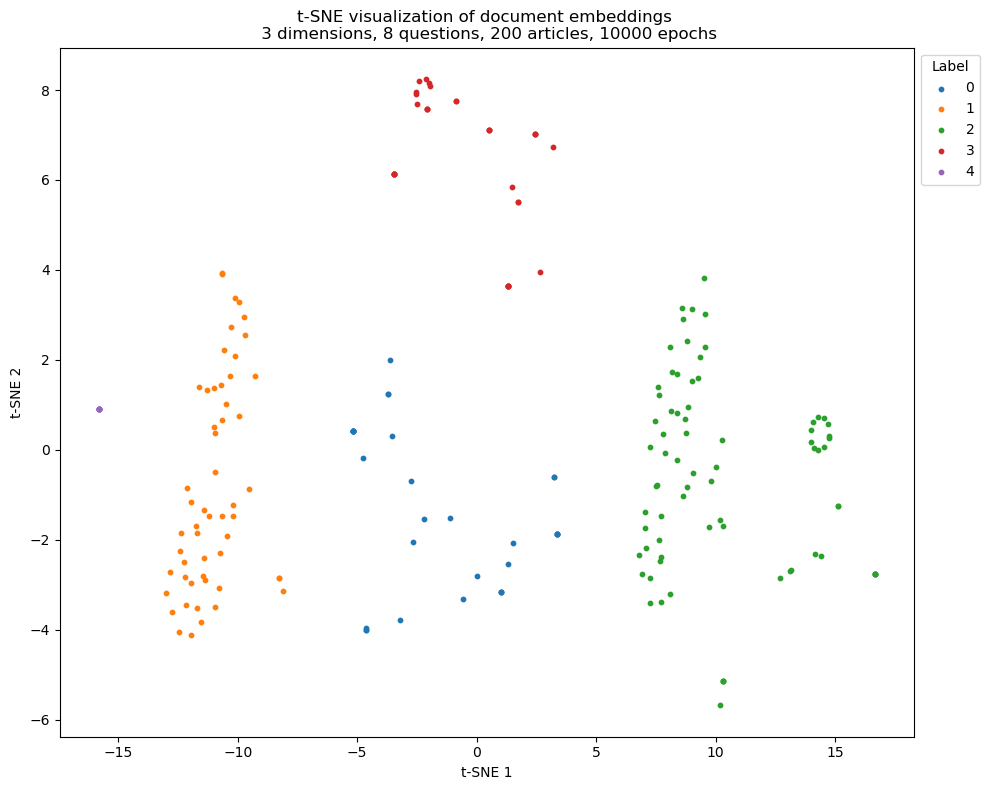

In [16]:
plt.figure(figsize=(10, 8))
for y in np.unique(labels):
    plt.scatter(
        v_2d[labels == y, 0], v_2d[labels == y, 1], label=f"{y}", s=10, marker="o"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)
plt.legend(title="Label", loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

In [17]:
# print the answers that has the same label
for i in range(labels.max() + 1):
    print(f"Label {i}")
    print(answers[labels == i])

Label 0
tensor([[4, 1, 4, 0, 1, 1, 1, 1],
        [3, 3, 3, 4, 3, 3, 3, 3],
        [1, 1, 1, 1, 1, 0, 1, 0],
        [4, 4, 4, 0, 4, 4, 4, 4],
        [4, 4, 4, 0, 0, 0, 0, 0],
        [1, 1, 1, 3, 4, 4, 1, 1],
        [4, 4, 4, 0, 0, 4, 4, 4],
        [4, 4, 4, 0, 0, 0, 0, 0],
        [4, 4, 4, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [4, 4, 4, 0, 4, 1, 1, 1],
        [1, 1, 1, 3, 1, 1, 1, 1],
        [1, 1, 1, 3, 1, 1, 1, 1],
        [4, 4, 4, 0, 0, 4, 4, 4],
        [4, 0, 4, 0, 0, 0, 0, 0],
        [1, 1, 1, 3, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 3, 1, 1, 1, 1],
        [4, 4, 4, 0, 4, 4, 4, 4],
        [4, 4, 4, 0, 0, 3, 0, 0],
        [4, 4, 4, 0, 4, 1, 4, 4],
        [4, 4, 4, 0, 4, 4, 4, 4],
        [4, 1, 1, 3, 1, 1, 1, 1],
        [1, 1, 1, 3, 1, 1, 1, 0],
        [4, 4, 4, 3, 4, 1, 1, 1],
        [1, 1, 1, 3, 1, 1, 1, 1],
        [1, 1, 1, 3, 4, 1, 1, 1],
        [1, 1, 1, 3, 4, 1, 1, 1],
      

In [18]:
# count the number of 0,1,2,3,4 in each question
for i in range(answers.shape[1]):
    print(f"Question {i+1}")
    print(np.unique(answers[:, i], return_counts=True))

Question 1
(array([0, 1, 2, 3, 4]), array([  1,  85,   4,   1, 109]))
Question 2
(array([0, 1, 2, 3, 4]), array([  2,  92,   4,   1, 101]))
Question 3
(array([0, 1, 2, 3, 4]), array([  1,  90,   4,   1, 104]))
Question 4
(array([0, 1, 2, 3, 4]), array([16, 72, 31, 23, 58]))
Question 5
(array([0, 1, 2, 3, 4]), array([ 9, 93,  8,  1, 89]))
Question 6
(array([0, 1, 2, 3, 4]), array([  8,  80,   4,   5, 103]))
Question 7
(array([0, 1, 2, 3, 4]), array([  7, 112,   4,   1,  76]))
Question 8
(array([0, 1, 2, 3, 4]), array([ 11, 106,   4,   1,  78]))


In [19]:
# print the index of the articles that has the same label
for i in range(labels.max() + 1):
    print(f"Label {i}")
    print(np.where(labels == i)[0])

Label 0
[  0  19  30  35  39  45  49  57  66  75  86  88  90  93  99 110 113 119
 121 126 127 135 139 140 168 170 171 173 174 175 179 197]
Label 1
[  1   2   3   5  10  13  16  20  25  28  31  33  46  48  53  56  61  62
  63  65  68  69  73  79  87  91 103 104 105 106 111 112 114 116 117 118
 124 130 133 143 145 153 155 158 159 160 161 162 165 178 185 191 192 193]
Label 2
[  4   6   7   8   9  11  12  14  15  21  22  23  34  36  38  40  41  43
  44  47  52  54  55  58  64  67  70  71  72  76  77  80  81  82  83  84
  85  89  92  94  95  97  98 100 101 108 109 122 132 136 137 138 141 142
 144 149 150 156 163 164 167 172 177 181 182 183 184 186 187 189 190 194
 195 196 198]
Label 3
[ 17  18  24  26  27  29  32  37  42  51  59  60  74  78  96 115 120 123
 125 128 134 146 147 148 151 152 157 166 169 176 180 188 199]
Label 4
[ 50 102 107 129 131 154]


In [20]:
np.savetxt("answers_4o.csv", answers, delimiter=",")

In [21]:
# save the label as interger to csv file
labels = labels.astype(int)
np.savetxt("labels_4o.csv", labels, delimiter=",")